In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
# import string
# from string import punctuation
# from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.utils import shuffle

! pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
# from sklearn import svm

# nltk.download('stopwords')
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

import re
import string

! pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

! pip install tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
import io
import json

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\saeed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saeed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saeed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/376.0 MB 5.6 MB/s eta 0:01:07
   ---------------------------------------- 2.9/376.0 MB 6.0 MB/s eta 0:01:03
   ---------------------------------------- 4.2/376.0 MB 6.3 MB/s eta 0:01:00
    --------------------------------------- 5.5/376.0 MB 6.2 MB/s eta 0:01:00
    --------------------------------------- 6.8/376.0 MB 6.2 MB/s eta 0:01:00
    --------------------------------------- 8.7/376.0 MB 6.5 MB/s eta 0:00:57
   - -------------------------------------- 9.4/376.0 MB 6.3 MB/s eta 0:00:59
   - -------------------------------------- 10.2/376.0 MB 6.1 MB/s eta 0:01:01
   - -------------------------------------- 11.8/376.0 MB 6.1 MB/s eta 0:01:01
   - -------------------------------------- 13.4/376.0 MB 6.2 MB/s eta 0:00:59
   - -------------------------------------- 14.2/376.0 MB 6.0 MB/s eta 0:01

In [11]:
analysis_set = pd.read_csv("csvs/AnalysisDataset.csv")

In [12]:
reviews = analysis_set["cleanedText"]
reviews = reviews.apply(lambda x: re.sub(r"\s+", " ", str(x)).strip() if isinstance(x, (str, float, int)) else x)

In [13]:
unseen_reviews = []
for review in reviews:
    unseen_reviews.append(review)

In [14]:
unseen_reviews

['lightweight soft much small liking would preferred two together make one loc reason repurchasing',
 'really like ear swab first come large handy box easy store last long time second organic good environment third strong fall apart easily highly recommend used year',
 'honest rarely used overnight cream typically skin care routine morning night wash apply hyalauronic serum kind moistutrizer saw iryasa cream wanted try easy apply immediately feel moisture starting work apply minute actually go sleep allow time absorbed putting face pillow thicker type cream need time skin morning feel better ever soft supple definitely feel difference using week highly recommend cream woman men',
 'ok good original wet brush knock',
 'purchased see could set mom hair fine thin short hair think could fun fluffy set mom super old school hoping little foam styling product',
 'great multi pack band great price wash well laundry lose elasticity',
 'easy use',
 'good way use face oil normally skip facial oil

In [15]:
with open('embedded.json') as f:
    data = json.load(f)
    loaded_tokenizer = tokenizer_from_json(data)

In [16]:
unseen_tokenized = loaded_tokenizer.texts_to_sequences(unseen_reviews)
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=100)

In [17]:
from keras.models import load_model

model_path = 'lstm_model.keras'
pretrained_lstm_model = load_model(model_path)
pretrained_lstm_model.summary()
preds = pd.Series()
preds = pretrained_lstm_model.predict(unseen_padded)
# unseen_sentiments

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     6,029,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,381,833 (24.34 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 6,029,700 (23.00 MB)

 Optimizer params: 234,756 (917.02 KB)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step


In [18]:
preds = (preds > 0.5).astype(int).flatten()

In [19]:
analysis_set["predictedSentiment"] = preds
analysis_set.head(1)

,Unnamed: 0,category,brand,item,rating,cleanedText,timestamp,numRating,average_rating,total_votes,popularity_score,predictedSentiment
0,0,All Beauty,niseyo,Niseyo new Faux Locs 24 Inch Crochet Hair 6 Pa...,3.0,lightweight soft much small liking would prefe...,2021-10-15 05:20:59.292,62.0,4.3,0,38.49,1


In [22]:
analysis_set.to_csv("csvs/Predictions.csv")

In [24]:
df = pd.DataFrame()
df = pd.read_csv("csvs/Predictions.csv")

In [25]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month']= df['timestamp'].dt.month

# Grouped months by their mean popularity scores

In [26]:
popularity_by_month = df.groupby(['category', 'month'])['popularity_score'].mean().div(1000).round(2).reset_index()

In [27]:
def get_top_categories_by_month(month_num):
    # Filter for the specific month
    month_data = popularity_by_month[popularity_by_month['month'] == month_num]
    
    # Sort by popularity_score in descending order and take top 5
    top_categories = month_data.sort_values('popularity_score', ascending=False).head(3)
    
    return top_categories

In [28]:
top_categories_by_month = {}
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

In [29]:
for i in range(1, 13):
    top_categories = get_top_categories_by_month(i)
    top_categories_by_month[month_names[i-1]] = top_categories

In [30]:
result_df = pd.DataFrame()

for month_name, top_data in top_categories_by_month.items():
    if not top_data.empty:
        # Add month name as a column
        top_data_with_month = top_data.copy()
        top_data_with_month['month_name'] = month_name
        
        # Append to result DataFrame
        result_df = pd.concat([result_df, top_data_with_month])

In [31]:
final_result = result_df[['month', 'month_name', 'category', 'popularity_score']].sort_values(
    by=['month', 'popularity_score'], 
    ascending=[True, False]
)

In [32]:
final_result.drop(columns=["month"], inplace=True)
final_result

,month_name,category,popularity_score
187,January,Gift Cards,43.44
36,January,Amazon Devices,21.09
144,January,Camera & Photo,18.38
37,February,Amazon Devices,55.95
188,February,Gift Cards,40.36
133,February,Buy a Kindle,28.15
189,March,Gift Cards,30.31
332,March,Prime Video,8.44
74,March,Appstore for Android,7.90
190,April,Gift Cards,27.07


In [34]:
df = pd.read_csv("csvs/Predictions.csv")

In [35]:
df['timestamp']= pd.to_datetime(df['timestamp'])
df['month']= df['timestamp'].dt.month

In [36]:
group= df.groupby(['category', 'month']).agg(totalReviews=('predictedSentiment', 'count'), positive=('predictedSentiment', 'sum')).reset_index()

In [37]:
group['ratio']= group['positive'] / group['totalReviews']
group['ratio']= group['ratio'].round(2)
# group

In [38]:
groupMonth= group.pivot(index= 'category', columns= 'month', values= 'totalReviews').fillna(0)
groupRatio= group.pivot(index= 'category', columns= 'month', values= 'ratio').fillna(0)

In [39]:
months= range(1, 13) #1 -> 12
month_names= ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']

#reindexs to make category not the index anymore
groupMonth= groupMonth.reindex(columns= months, fill_value= 0.0).astype(float)
groupRatio= groupRatio.reindex(columns= months, fill_value= 0).astype(float)

In [40]:
totalRatio= pd.concat([
    groupMonth.rename(columns= dict(zip(months, [f"{i}_Total"for i in month_names]))),
    groupRatio.rename(columns= dict(zip(months, [f"{i}_Ratio"for i in month_names])))
], axis= 1)

In [41]:
columnOrder= []
for i in month_names:
    columnOrder.extend([f"{i}_Total", f"{i}_Ratio"])

In [ ]:
totalRatio= totalRatio[columnOrder].reset_index()

In [43]:
totalCols= [col for col in totalRatio.columns if '_Total' in col]
totalRatio[totalCols]= totalRatio[totalCols].astype(int)

In [44]:
totalRatio

month,category,January_Total,January_Ratio,February_Total,February_Ratio,March_Total,March_Ratio,April_Total,April_Ratio,May_Total,...,August_Total,August_Ratio,September_Total,September_Ratio,October_Total,October_Ratio,November_Total,November_Ratio,December_Total,December_Ratio
0,AMAZON FASHION,95,0.86,62,0.89,86,0.90,89,0.91,75,...,69,0.93,67,0.91,81,0.91,57,0.89,74,0.88
1,All Beauty,130,0.90,105,0.86,127,0.92,110,0.80,120,...,129,0.84,89,0.82,92,0.86,100,0.88,123,0.81
2,All Electronics,45,0.82,31,0.87,18,0.72,16,0.81,16,...,13,0.85,23,0.96,21,0.86,19,1.00,34,0.91
3,Amazon Devices,4,1.00,1,1.00,0,0.00,3,1.00,1,...,3,1.00,1,1.00,0,0.00,2,1.00,4,1.00
4,Amazon Home,201,0.89,142,0.88,157,0.83,155,0.88,154,...,145,0.88,115,0.87,165,0.83,159,0.91,164,0.84
5,Apple Products,0,0.00,2,1.00,0,0.00,1,0.00,0,...,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00
6,Appliances,42,0.86,29,0.86,38,0.95,25,0.88,26,...,29,0.90,35,0.91,36,0.89,32,0.78,46,0.91
7,Appstore for Android,89,0.79,60,0.82,65,0.77,64,0.72,65,...,71,0.69,75,0.73,76,0.78,43,0.74,70,0.73
8,"Arts, Crafts & Sewing",10,0.90,18,0.94,10,1.00,13,0.85,15,...,18,0.83,18,0.94,10,0.90,16,0.88,9,0.67
9,Automotive,14,0.71,13,0.85,11,0.91,8,0.75,16,...,10,1.00,10,0.90,11,1.00,13,0.85,9,0.89


# Visualization for all categories and their popularity over the months

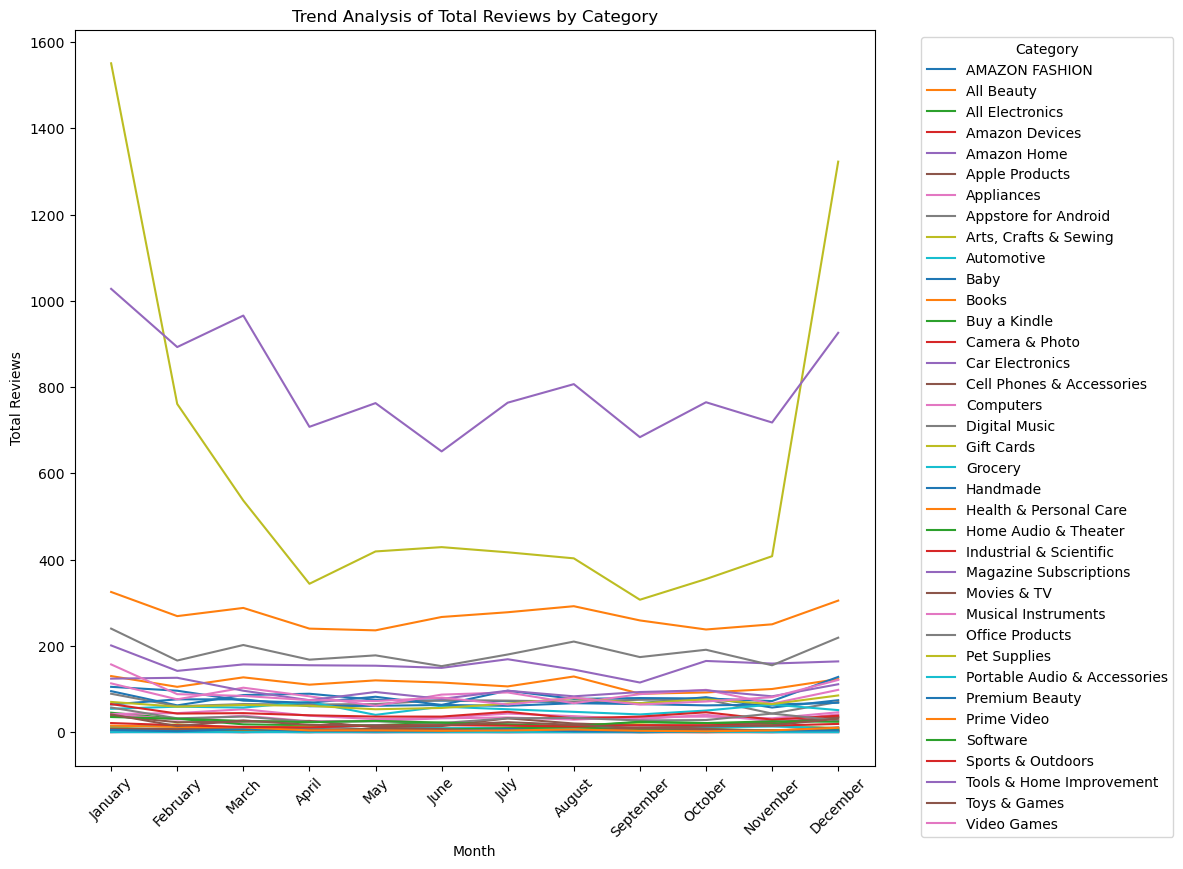

In [53]:
#get total columns
totalCols = [col for col in totalRatio.columns if '_Total' in col]

#melt the frame
melted= totalRatio.melt(id_vars='category', value_vars=totalCols, var_name='Month', value_name='TotalReviews')

melted['Month'] = melted['Month'].str.replace('_Total', '')
melted['Month'] = pd.Categorical(melted['Month'], categories=month_names, ordered=True)

#plot 
plt.figure(figsize=(12, 9))
for category in melted['category'].unique():
    category_data = melted[melted['category'] == category]
    plt.plot(category_data['Month'], category_data['TotalReviews'], label=category)

#supposed to get the max value but it dont work :\
# max_point = category_data.loc[category_data['TotalReviews'].idxmax()]
# plt.text(max_point['Month'], max_point['TotalReviews'], category, fontsize=9, ha='center', va='bottom')

plt.title('Trend Analysis of Total Reviews by Category')
plt.xlabel('Month')
plt.ylabel('Total Reviews')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization for single category popularity

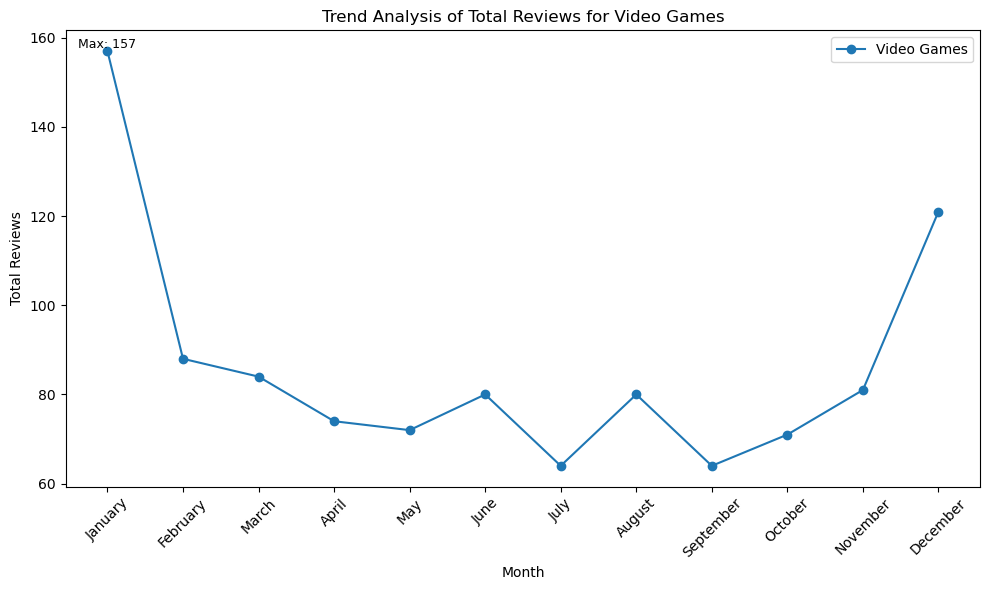

In [86]:
#The category you want to plot
selected= "Video Games"

#melt frame
category_data = melted[melted['category'] == selected]

#Plot
plt.figure(figsize=(10, 6))
plt.plot(category_data['Month'], category_data['TotalReviews'], marker='o', label=selected)

# show the max value
max_point = category_data.loc[category_data['TotalReviews'].idxmax()]
plt.text(max_point['Month'], max_point['TotalReviews'], f"Max: {max_point['TotalReviews']}", 
         fontsize=9, ha='center', va='bottom')

plt.title(f'Trend Analysis of Total Reviews for {selected}')
plt.xlabel('Month')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
#dataframe for brand information
brandTotal= df.groupby(['category', 'brand', 'month']).agg(totalReviews=('predictedSentiment', 'count'), positive=('predictedSentiment', 'sum')).reset_index()

brandTotal['ratio']= (brandTotal['positive'] / brandTotal['totalReviews']).round(2)

#pivot for reviews and ratios
brandMonth= brandTotal.pivot(index= ['category', 'brand'], columns= 'month', values= 'totalReviews').fillna(0)
brandRatio= brandTotal.pivot(index= ['category', 'brand'], columns= 'month', values= 'ratio').fillna(0)

#concat frames
# brandFinal= pd.concat(
#     [brandMonth.add_suffix('_Total'), brandRatio.add_suffix('_Ratio')]
# , axis= 1).reset_index()
brandFinal= pd.concat([
    brandMonth.rename(columns= dict(zip(months, [f"{i}_Total"for i in month_names]))),
    brandRatio.rename(columns= dict(zip(months, [f"{i}_Ratio"for i in month_names])))
], axis= 1)

# columnOrder= []
# for i in month_names:
#     columnOrder.extend([f"{i}_Total", f"{i}_Ratio"])

brandFinal= brandFinal[columnOrder].reset_index()

totalCols= [col for col in brandFinal.columns if '_Total' in col]
brandFinal[totalCols]= brandFinal[totalCols].astype(int)

# #sort by category
# brandTotal= brandTotal.sort_values(by=['category'])

brandFinal.head(1)

month,category,brand,January_Total,January_Ratio,February_Total,February_Ratio,March_Total,March_Ratio,April_Total,April_Ratio,...,August_Total,August_Ratio,September_Total,September_Ratio,October_Total,October_Ratio,November_Total,November_Ratio,December_Total,December_Ratio
0,AMAZON FASHION,acefeel,0,0.0,0,0.0,0,0.0,0,0.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


# Visualization for top 10 brands in a category and their popularity

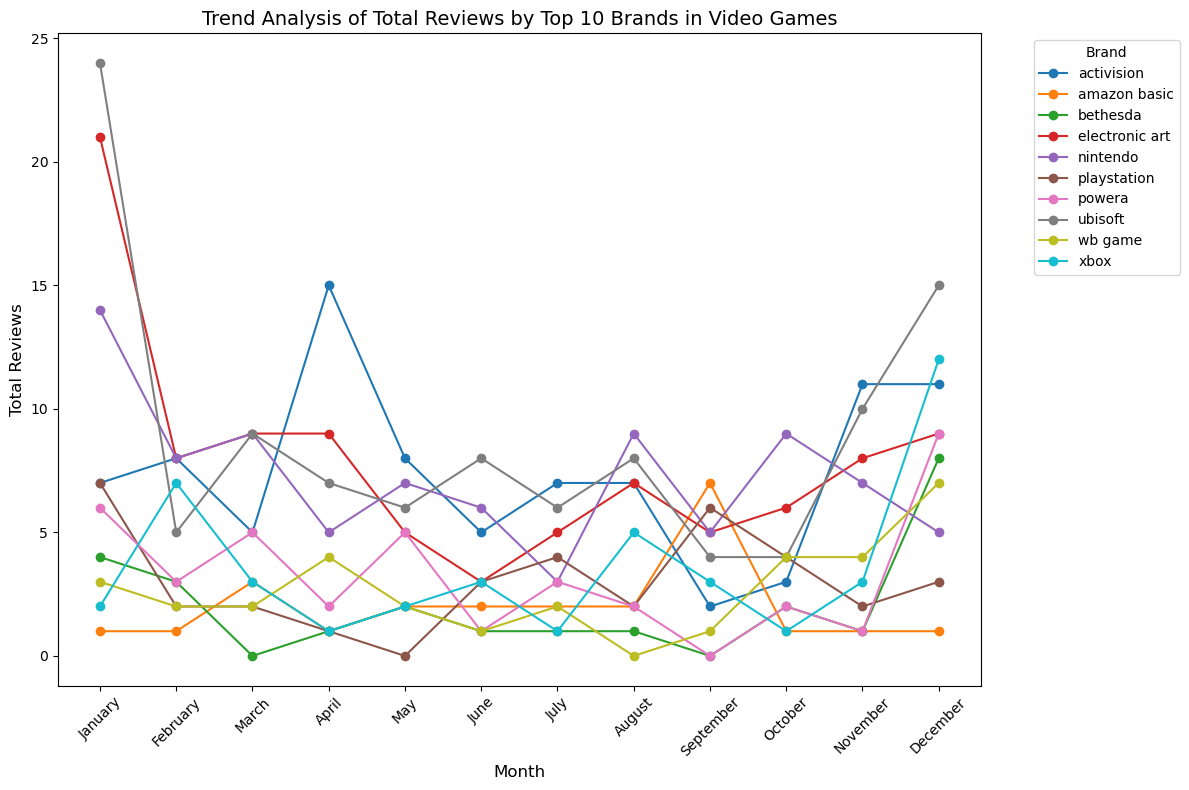

In [85]:
# Define the category you want to visualize
selected_category = "Video Games"  # Replace with the actual category name

# Filter the DataFrame for the selected category
category_brands = brandTotal[brandTotal['category'] == selected_category]

# Calculate the total reviews for each brand across all months
brand_totals = category_brands.groupby('brand')['totalReviews'].sum().reset_index()

# Get the top 10 brands by total reviews
top_10_brands = brand_totals.nlargest(10, 'totalReviews')['brand']

# Filter the original DataFrame to include only the top 10 brands
top_brands_data = category_brands[category_brands['brand'].isin(top_10_brands)]

# Pivot the data to have months as columns for totalReviews
brand_monthly_reviews = top_brands_data.pivot(index='brand', columns='month', values='totalReviews').fillna(0)

# Plot the trend for each of the top 10 brands
plt.figure(figsize=(12, 8))
for brand in brand_monthly_reviews.index:
    plt.plot(brand_monthly_reviews.columns, brand_monthly_reviews.loc[brand], marker='o', label=brand)

# Add labels and title
plt.title(f'Trend Analysis of Total Reviews by Top 10 Brands in {selected_category}', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Reviews', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()